# Predicting house prices: A regression example
---

The previous examples were considered classification problems, where the goal was to predict a single discrete label of an input data point. Another common type of machine learning problem is **regression**, which consists of predicting a continuous value instead of a discrete label: for instance, predicting the temperature tomorrow, given meteorological data or predicting the time that a software project will take to complete, given its specifications.

## The Boston housing price dataset

we’ll attempt to predict the median price of homes in a given Boston
suburb in the mid-1970s, given data points about the suburb at the time, such as the crime rate, the local property tax rate, and so on.

The dataset has relatively few data points: only 506, split between 404 training samples and 102 test samples. And each feature in the input data (for example, the crime rate) has a different scale. For instance, some values are proportions, which take values between 0 and 1, others take values between 1 and 12, others between 0 and 100, and so on.


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import to_categorical

# this module has the mnist data set
from tensorflow.keras.datasets import boston_housing

import numpy as np
import matplotlib.pyplot as plt

### Load and visualize the data set 

In [ ]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [ ]:
print(f"Train data shape: {train_data.shape}")
print(f"Train targets shape: {train_targets.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Test targets shape: {test_targets.shape}")

print("Sample data:\n", train_data[0])
print("Sample target:\n", train_targets[0])

Train data shape: (404, 13)
Train targets shape: (404,)
Test data shape: (102, 13)
Test targets shape: (102,)
Sample data:
 [  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
Sample target:
 15.2


We have 404 training samples and 102 test samples, each with 13
numerical features, such as per capita crime rate, average number of rooms per dwelling, accessibility to highways, and so on:

- crim: per capita crime rate by town.
- zn: proportion of residential land zoned for lots over 25,000 sq.ft.
- indus: proportion of non-retail business acres per town.
- chas: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
- nox: nitrogen oxides concentration (parts per 10 million).
- rm: average number of rooms per dwelling.
- age: proportion of owner-occupied units built prior to 1940.
- dis: weighted mean of distances to five Boston employment centres.
- rad: index of accessibility to radial highways.
- tax: full-value property-tax rate per \$10,000.
- ptratio: pupil-teacher ratio by town.
- black: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
- lstat: lower status of the population (percent).

The targets are the median values of owner-occupied homes, in thousands of dollars.

### Data preparation

A widespread best practice for dealing with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation.

In [ ]:
train_mean = train_data.mean(axis = 0)
train_std = train_data.std(axis = 0)

np.set_printoptions(precision=6, suppress=True)
print("Mean:\n", train_mean)
print("STD:\n", train_std)

print("Data before standadization:\n", train_data[0])

train_data_standard = train_data - train_mean
test_data_standard = test_data - train_mean

train_data_standard /= train_std
test_data_standard /= train_std

print("Data after standadization:\n", train_data_standard[0])

Mean:
 [  3.745111  11.480198  11.104431   0.061881   0.557356   6.267082
  69.010644   3.740271   9.440594 405.898515  18.47599  354.783168
  12.740817]
STD:
 [  9.229291  23.738277   6.802873   0.24094    0.117148   0.708909
  27.906063   2.0277     8.687588 166.168506   2.197657  93.994601
   7.245561]
Data before standadization:
 [  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
Data after standadization:
 [-0.272246 -0.483615 -0.435762 -0.256833 -0.165227 -0.176443  0.813062
  0.116698 -0.626249 -0.59517   1.1485    0.448077  0.82522 ]


Note that the quantities used for normalizing the test data are computed using the training data. You should never use any quantity computed on the test data in your workflow, even for something as simple as data normalization.

### Model definition

Because so few samples are available, we’ll use a very small model with two intermediate layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using a small model is one way to mitigate overfitting.

In [ ]:
def build_model():
  model = models.Sequential([
    layers.Dense(32, activation = 'relu', input_shape=(13,)),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(1)
  ])
  
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  
  return model

For the optimizer, we'll use **rmsprop**. 

RMSprop is a gradient based optimization technique used in training neural networks. It was proposed by the father of back-propagation, Geoffrey Hinton. Gradients of very complex functions have a tendency to either vanish or explode as the data propagates through the function (vanishing gradients problem). 

RMSprop deals with the above issue by using a moving average of squared gradients to normalize the gradient. This normalization balances the step size, decreasing the step for large gradients to avoid exploding, and increasing the step for small gradients to avoid vanishing. 

Basically, RMSprop uses an adaptive learning rate instead of treating the learning rate as a hyperparameter. This means that the learning rate changes over time.

Note that we compile the model with the mse loss function—mean squared error, the square of the difference between the predictions and the targets. This is a widely used loss function for regression problems.

We’re also monitoring a new metric during training: mean absolute error (MAE). It’s the absolute value of the difference between the predictions and the targets. For instance, an MAE of 0.5 on this problem would mean your predictions are off by $500 on average.

### Validating the model

To evaluate we could split the data into a training set and a validation set. But because we have so few data points, the validation set would end up being very small. As a consequence, the validation scores might change a lot depending on which data points we chose for validation and which we chose for training.

The best practice in such situations is to use K-fold cross-validation. It consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K – 1 partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the K validation scores obtained.


![K fold](https://cdn-images-1.medium.com/max/1009/1*1RPHQk-xpKMInxkEd1qFyg.png)

In [ ]:
# k-fold validation
k = 4

num_val_samples = len(train_data) // k

mae_histories = []
val_mae_histories = []

num_epochs = 500

for i in range(k):
  print("Processing fold: ", i)
  
  val_data = train_data_standard[i * num_val_samples : (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
  
  partial_train_data = np.concatenate([train_data_standard[:i*num_val_samples], 
                                       train_data_standard[(i+1) * num_val_samples:]], 
                                      axis = 0)
  
  partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], 
                                          train_targets[(i+1) * num_val_samples:]], 
                                         axis = 0)

  model = build_model()
  
  history = model.fit(partial_train_data, partial_train_targets, 
                      epochs = num_epochs, validation_data = (val_data, val_targets), 
                      batch_size = 16, verbose = 0)
  
  mae_histories.append(history.history['mae'])
  val_mae_histories.append(history.history['val_mae'])
  

Processing fold:  0
Processing fold:  1
Processing fold:  2
Processing fold:  3


### Visualizing the results

<Figure size 432x288 with 0 Axes>

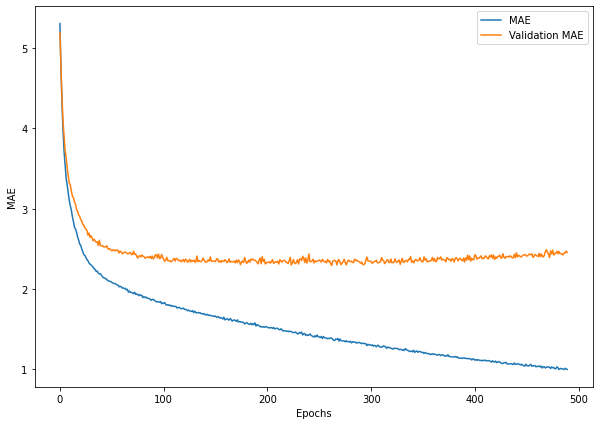

In [ ]:
average_mae_history = [ np.mean([x[i] for x in mae_histories]) for i in range(num_epochs)]
average_val_mae_history = [np.mean([x[i] for x in val_mae_histories]) for i in range(num_epochs)]

plt.clf()
plt.figure(figsize=(10,7))
plt.plot(average_mae_history[10:], label="MAE")
plt.plot(average_val_mae_history[10:], label="Validation MAE")
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.show()

After the validation process, we can train a final model after adjusting the hyperparameters, and look at its performance on the test data.

In [ ]:
model = build_model()

history = model.fit(train_data_standard, train_targets, epochs = 80, batch_size = 16, verbose = 0)

test_mse, test_mae = model.evaluate(test_data_standard, test_targets)

print(f"Mse: {test_mse} Mae: {test_mae}")

4/4 [==============================] - 0s 3ms/step - loss: 18.6021 - mae: 2.8437
Mse: 18.60207176208496 Mae: 2.8436787128448486


<Figure size 432x288 with 0 Axes>

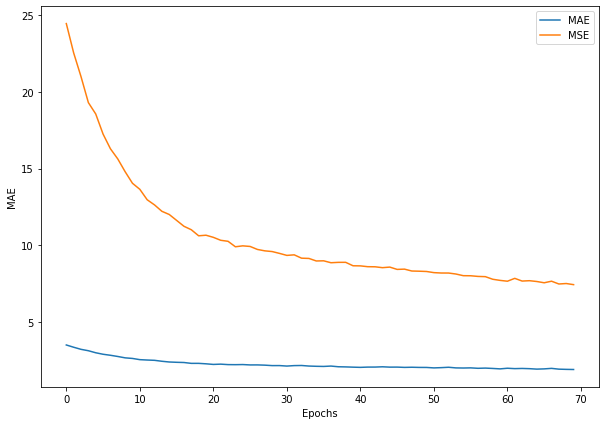

In [ ]:
plt.clf()
plt.figure(figsize=(10,7))
plt.plot(history.history['mae'][10:], label="MAE")
plt.plot(history.history['loss'][10:], label="MSE")
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.show()

Now, with this scalar regression model, predict() returns the model’s guess for the sample’s price in thousands of dollars.

In [ ]:
predictions = model.predict(test_data_standard)

predictions_targets = np.column_stack((test_targets, predictions))
print(f"Expecter target vs Prediction:\n{predictions_targets[:10]}")


Expecter target vs Prediction:
[[ 7.2       8.213581]
 [18.8      18.164703]
 [19.       21.5441  ]
 [27.       32.627876]
 [22.2      25.16077 ]
 [24.5      21.481667]
 [31.2      26.221592]
 [22.9      21.323547]
 [20.5      19.581001]
 [23.2      21.832079]]
